In [63]:
import pandas as pd
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow 
import autokeras as ak
import scipy.io
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [47]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y = df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=False)

In [48]:
# It tries 10 different models.
reg = ak.StructuredDataRegressor(max_trials=30, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=30)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))

Trial 28 Complete [00h 02m 08s]
val_loss: 3.0910139083862305

Best val_loss So Far: 1.3315867185592651
Total elapsed time: 00h 41m 06s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
2190/2190 [==============================] - 5s 2ms/step - loss: 870.4645 - mean_squared_error: 870.4645
Epoch 2/30
2190/2190 [==============================] - 3s 1ms/step - loss: 12.5619 - mean_squared_error: 12.5619
Epoch 3/30
2190/2190 [==============================] - 3s 1ms/step - loss: 7.8028 - mean_squared_error: 7.8028
Epoch 4/30
2190/2190 [==============================] - 3s 1ms/step - loss: 6.6346 - mean_squared_error: 6.6346
Epoch 5/30
2190/2190 [==============================] - 3s 1ms/step - loss: 6.0575 - mean_squared_error: 6.0575
Epoch 6/30
2190/2190 [==============================] - 5s 2ms/step - loss: 5.6226 - mean_squared_error: 5.6226
Epoch 7/30
2190/2190 [==============================] - 2s 1ms/step - loss: 5.2069 - mean_squared_error: 5.2069: 0s - loss: 5.6294 - mean_squared_err

2021-10-25 15:00:48.787493: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets
939/939 [==============================] - 1s 930us/step - loss: 3.4909 - mean_squared_error: 3.4909
[3.49086332321167, 3.49086332321167]


In [49]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1)                 33        
Total params: 202
Trainable params: 193
Non-trainable params: 9
_______________________________________________________________

In [50]:
model.save("model_autokeras_temp_v2", save_format="tf")

INFO:tensorflow:Assets written to: model_autokeras_temp_v2/assets


In [54]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model_autokeras_temp_v2", custom_objects=ak.CUSTOM_OBJECTS)
predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))

<IPython.core.display.Javascript object>

1.5003252166338357


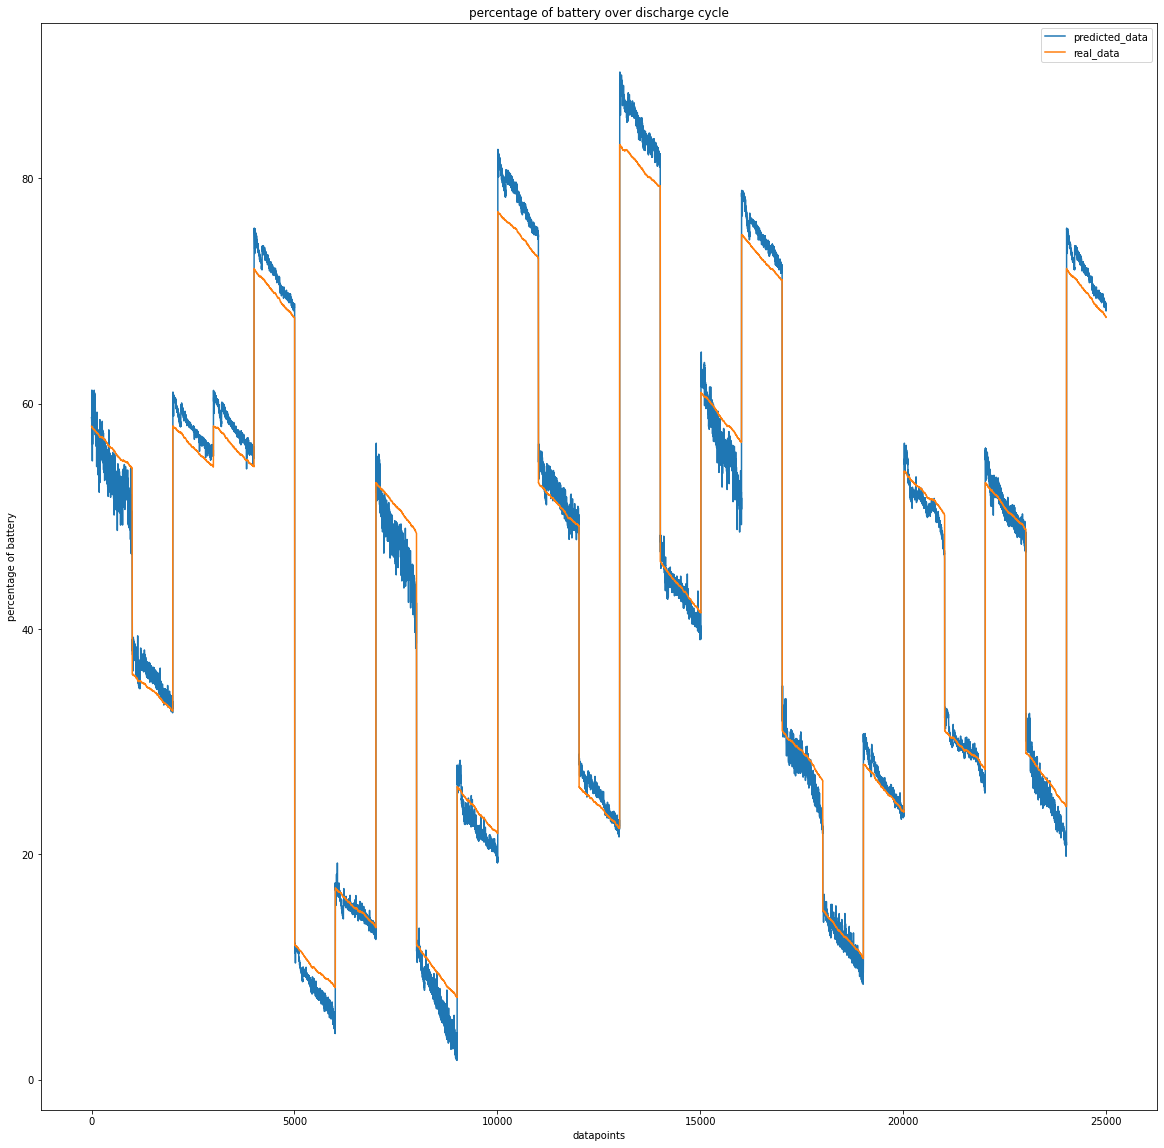

In [57]:
X = np.linspace(0,25000,25000)
print(mean_absolute_error(predicted_y,y_test))
plt.figure(figsize=(20,20))
plt.plot(X,predicted_y[0:25000], label='predicted_data')
plt.plot(X,y_test[0:25000], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()

In [61]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y = df.SOC_tot
model = XGBRegressor(#colsample_bytree=0.98,
                    gamma=0.64,
                    learning_rate=0.03,
                    max_depth=18,
                    min_child_weight=5,
                    n_estimators=150,
                    reg_alpha=0.39,
                    reg_lambda=4.27,
                    seed=42)
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.64, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=18,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.39,
             reg_lambda=4.27, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.3805938707897789


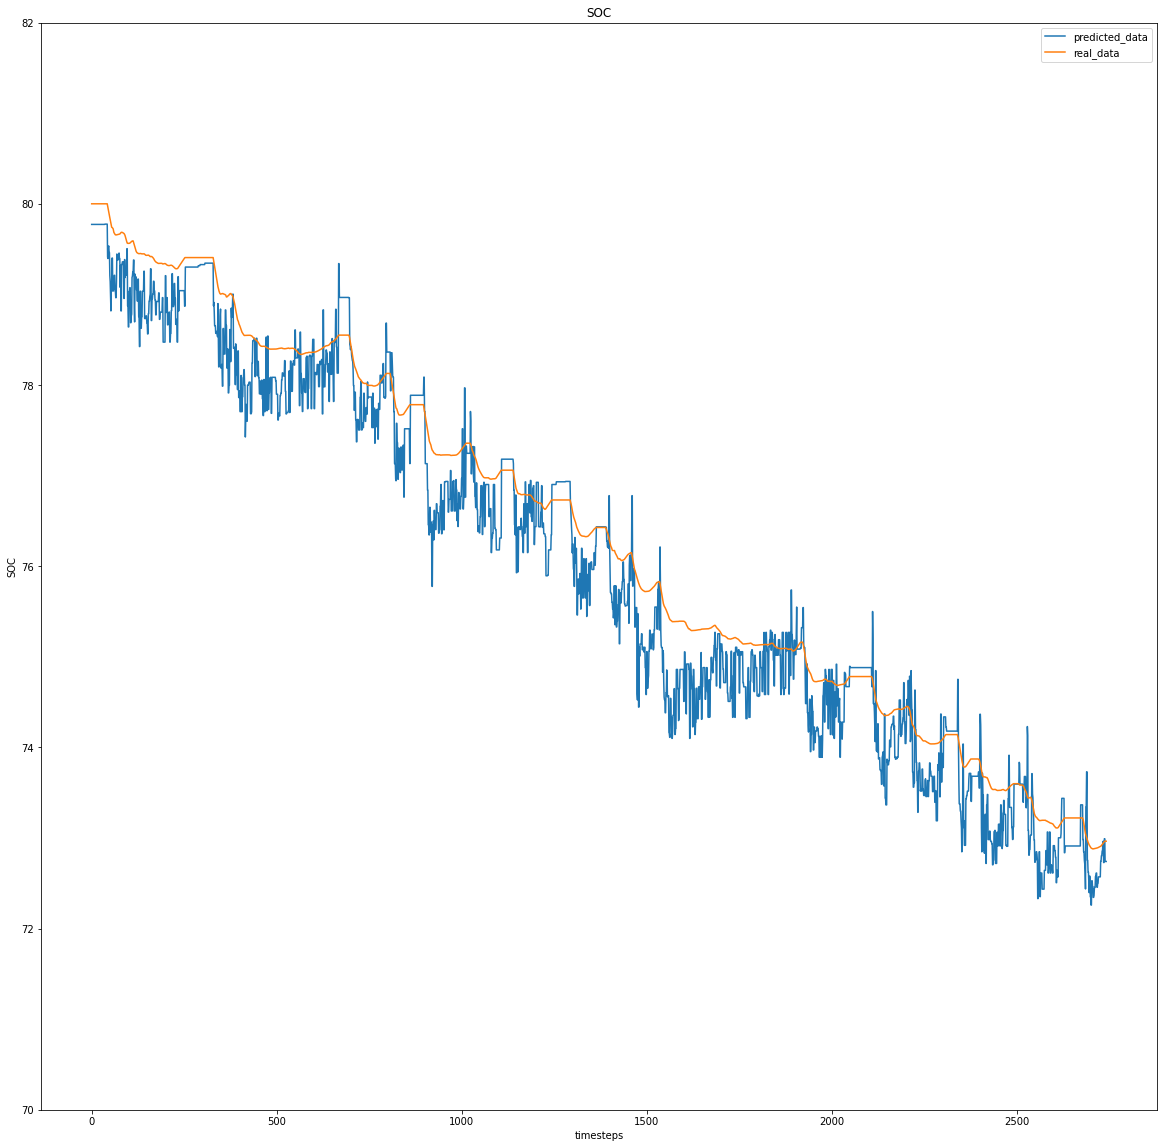

In [62]:
df_test = pd.read_csv('/Users/monmac/Desktop/udds.csv')

X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

#scaled_X_test = Xscaler.transform(X_test)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

data=model.predict(X_test)
print(mean_absolute_error(data,y_test))


len1 = len(data)

X_len1 = np.linspace(0,len1,len1)

plt.figure(figsize=(20,20))
plt.plot(X_len1,data, label='predicted_data')
plt.plot(X_len1,y_test, label='real_data')
plt.title('SOC')
plt.xlabel('timesteps')
plt.ylabel('SOC')
plt.legend()
plt.ylim(70,82)
plt.show()

6.4252391760519005


<IPython.core.display.Javascript object>

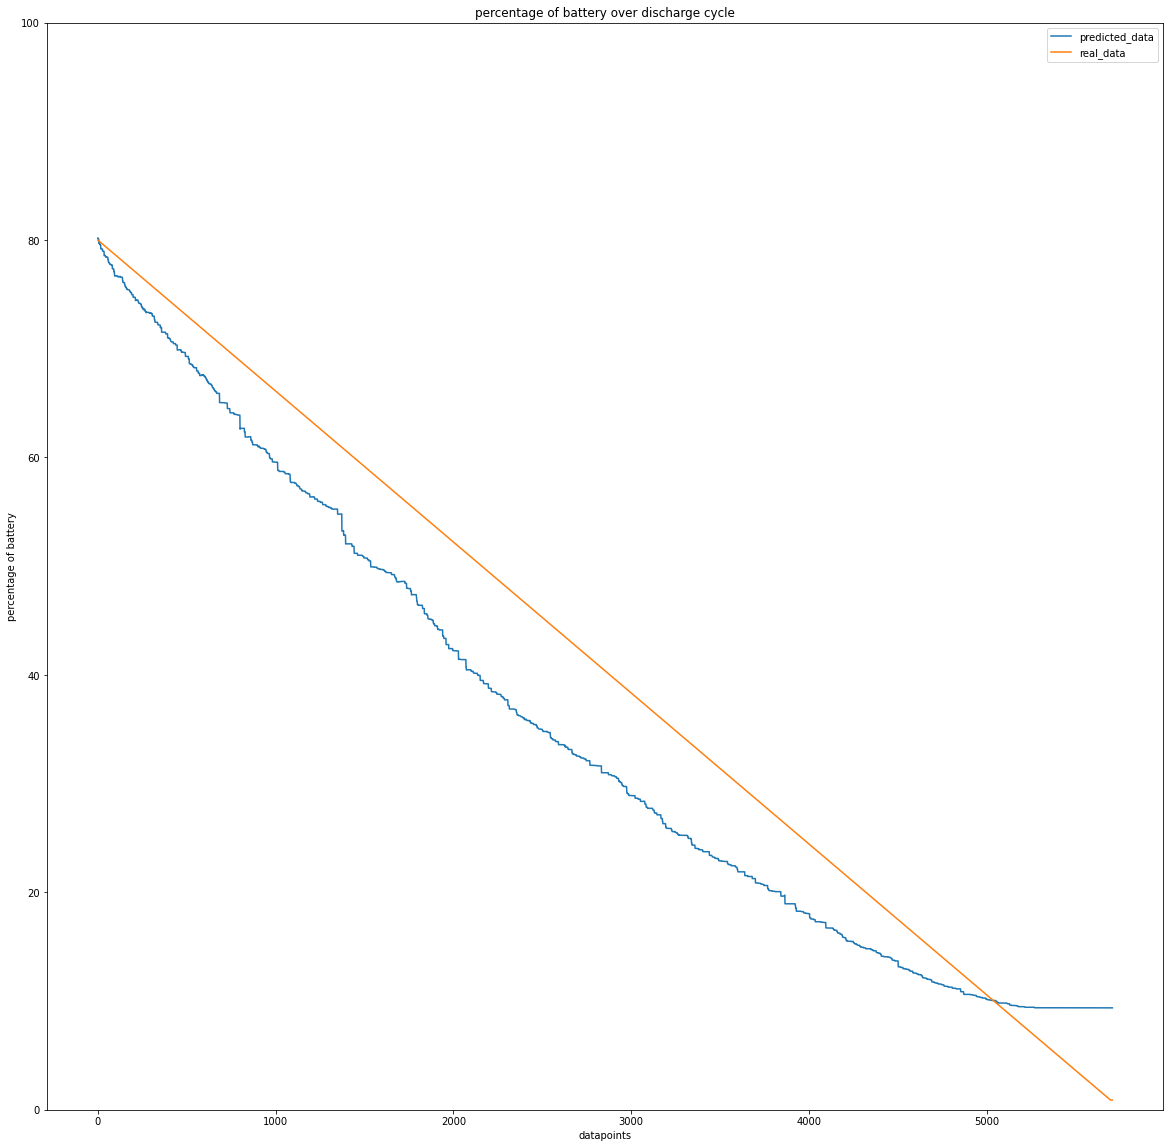

In [11]:
df_test = pd.read_csv('../raw_data/current_discharge.csv')

X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

#scaled_X_test = Xscaler.transform(X_test)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

data=model.predict(X_test)
print(mean_absolute_error(data,y_test))


len1 = len(data)

X_len1 = np.linspace(0,len1,len1)

plt.figure(figsize=(20,20))
plt.plot(X_len1,data, label='predicted_data')
plt.plot(X_len1,y_test, label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.ylim(0,100)
plt.show()

In [166]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/Results2/*.txt")))) # read data 

df_test = pd.read_csv('/Users/monmac/Desktop/udds.csv')

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) # read data 
#y_col='SOC_tot' # define y variable, i.e., what we want to predict
#test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
#train = df.iloc[:-test_size,:].copy() 
# Try using .loc[row_index,col_indexer] = value instead
#test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' # define y variable, i.e., what we want to predict

train = df.iloc[:,:].copy() 
# Try using .loc[row_index,col_indexer] = value instead
test = df_test.iloc[:,:].copy() 


X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series
print(y_train.shape)

Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 8 # Number of timeseries samples in each batch

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
#model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=1)

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})



(100100, 1)


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12510/12510 [==============================] - 86s 7ms/step - loss: 0.0073


6.547730688739484


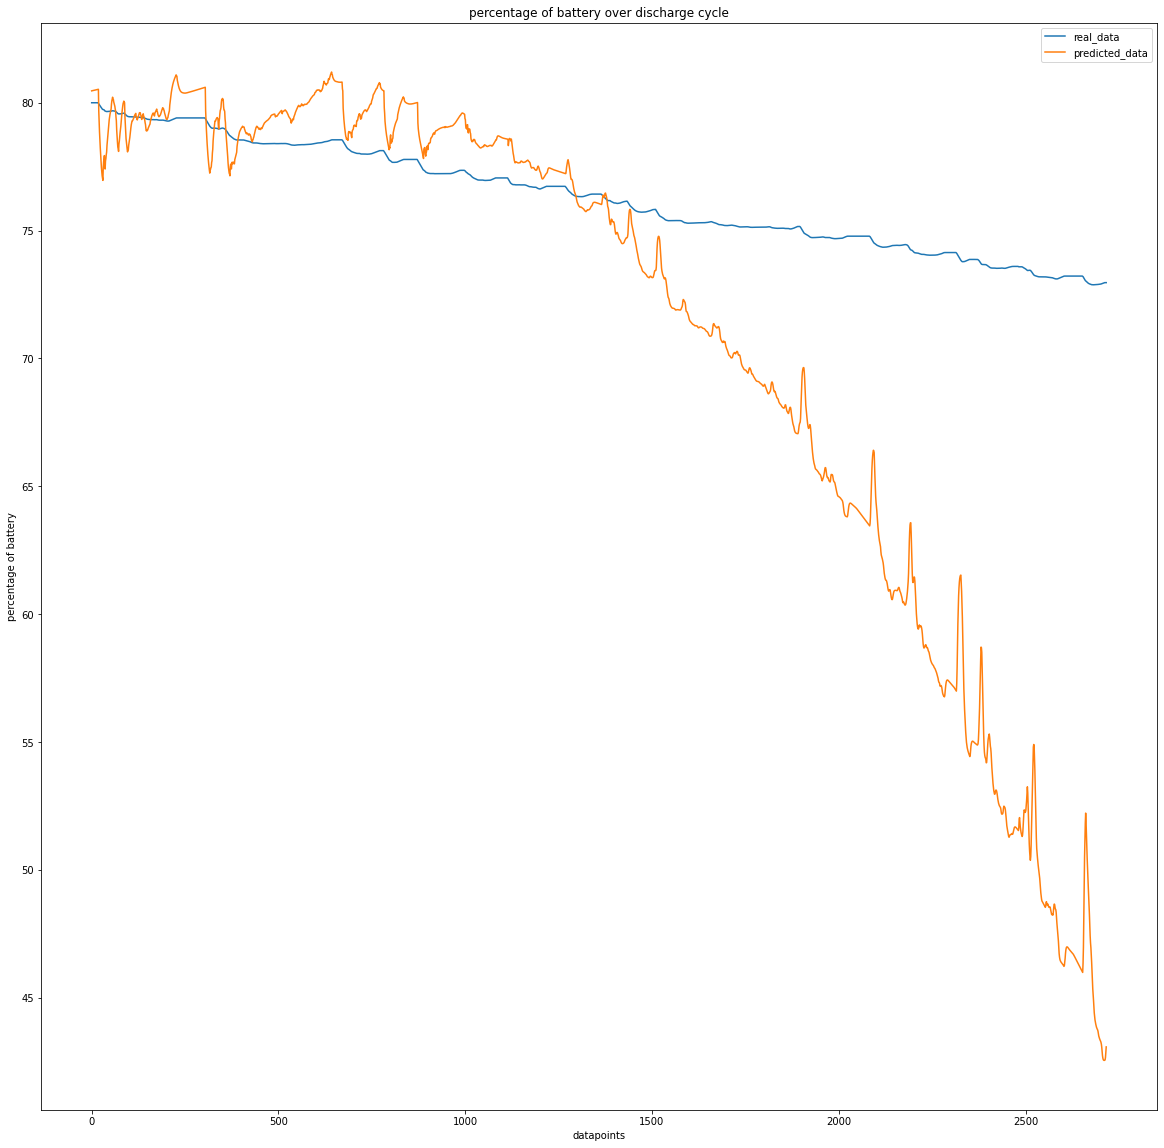

In [167]:
len1 = len(results)
X = np.linspace(0,len1,len1)
plt.figure(figsize=(20,20))
print(mean_absolute_error(results['y_true'],results['y_pred']))
plt.plot(X,results['y_true'], label='real_data')
plt.plot(X,results['y_pred'], label='predicted_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()